In [1]:
import tensorflow as tf
import numpy as np
import copy
import math as math
import time
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Part a

In [2]:
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

#learning rate
lr = 0.1
#number of maximum traning steps
max_steps =1000
#number of batch_size
batch_size = 128
num_classes = 10 # number of output features
n_hidden = 20
lamb = 0.1

# Part b, c, & d

In [3]:
def softmax(X):
    x_softmax = np.zeros(X.shape)
    for i,x in enumerate(X):
        e_x = np.exp(x - np.max(x+1e-10))
        e_x = e_x/e_x.sum()
        x_softmax[i,:] = e_x
    return x_softmax
def relu(z): 
    relu_z = z
    relu_z[relu_z < 0] = 0
    return relu_z
def relu_deriv(z):
    relu_d = z
    relu_d[relu_d <= 0] = 0
    relu_d[relu_d > 0] = 1
    return relu_d
def add_bias(X):
    X_bias = np.ones((X.shape[0], X.shape[1] + 1))
    X_bias[:,1:] = X
    return X_bias
def forward(X,Y, w1,w2):
    a1 = add_bias(X) # n by d+1
    z2 = np.dot(a1, w1) # n by h
    a2 = add_bias(relu(z2)) # n by h+1
    z3 = np.dot(a2, w2) # n by o
    a3 = softmax(z3) # n by o
    return a1, z2, a2, z3, a3
def compute_cost(Y, Y_hat):
    n, o = Y.shape
    running_cost = 0
    entropy= -np.sum(Y*np.log(Y_hat+1e-20), axis = 1);
    return np.mean(entropy)
def backpropagate(y,y_hat,a1,z2,a2,z3, w1,w2):
    n = y.shape[0]
    delta = y-y_hat # n by o
    z2_prime = relu_deriv(add_bias(z2)) #n by h+1
    sigmoid = np.dot(delta, w2.T)*z2_prime# n by h+1
    sigmoid = sigmoid[:,1:] # n by h
    dJ_w1 = np.dot(a1.T, sigmoid) # d+1 by h
    dJ_w2 = np.dot(a2.T, delta) # h+1 by o
    dJ_w1[:,1:]+= 2*0.01*w1[:,1:]
    dJ_w2[:,1:]+= 2*0.01*w2[:,1:]
    return dJ_w1, dJ_w2

# Part c

In [4]:
def gradient_descent(X, Y, X_test, Y_test, learning_rate= 0.01, batch_size = 128,max_steps = 1000):
    n,d = X_train.shape
    m,o = Y_test.shape
    print('Gradient Descent')
    w1 = np.random.uniform(-1.0, 1.0, size = (d+1,n_hidden)) 
    w2 = np.random.uniform(-1.0, 1.0, size = (n_hidden+1,o))
    
    w1_list,w2_list, b1_list,b2_list = [],[],[],[]
    iters, delta = 0, 1e-20
    J_train, J_test = [],[]
    loss_old = 0
    start = time.time()
    while iters < max_steps:
#         print(iters,max_steps)
        w1_old = copy.copy(w1)       
        w2_old = copy.copy(w2)       
        w1_list.append(w1_old)      
        w2_list.append(w2_old)
        l_train, l_test = 0,0
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        a1, z2, a2, z3, y_hat = forward(batch_x, batch_y, w1,w2)
        dJ_w1, dJ_w2 = backpropagate(batch_y,y_hat,a1, z2, a2, z3, w1,w2)
#         n, d = batch_x.shape
#         for i in range(n):
#             z = forwa
#             mu = -np.sum(np.log(Y_test[i]-(b+np.dot(X_test[i,:], w))))
#             dJ_w += -(1-mu)*Y[i,:]*np.reshape(X[i,:], (d,1))
#             dJ_b += -(1-mu)*Y[i,:]
#             l_train += np.log(1/mu)
#         dJ_w = dJ_w/n+2*lamb*w

        dJ_w1 = dJ_w1/batch_size
        dJ_w2 = dJ_w2/batch_size
        w1 += learning_rate*dJ_w1
        w2 += learning_rate*dJ_w2

        a1, z2, a2, z3,y_hat_train = forward(X_train, Y_train,w1,w2)
        a1, z2, a2, z3,y_hat_test = forward(X_test, Y_test,w1,w2)
        l_train = compute_cost(Y_train,y_hat_train)
        l_test = compute_cost(Y_test,y_hat_test)
        J_train.append(l_train)
        J_test.append(l_test)
        if iters % 10 == 0:
            print('Current Loss: (iter :', iters+1,')', l_train, l_test)
        if np.mean((w1_old - w1) ** 2)+ np.mean((w2_old - w2) ** 2) < delta:
            break;
        if iters > 100 and np.abs(l_train - loss_old)< 1e-3:
            break;
        loss_old = copy.copy(l_train)
        iters += 1
    end = time.time()
    runtime = end-start
    return J_train, J_test, runtime


In [5]:
def draw_loss(J_train, J_test, descent_type = ''):
    iterations = range(len(J_train))
    plt.plot(iterations, J_train, label='Loss in train set')
    plt.plot(iterations, J_test, label='Loss in test set')
    plt.xlabel('iteration count')
    plt.ylabel('Loss')
    plt.title('J(w,b) vs. iteration '+descent_type)
    plt.legend()
    plt.show()

Gradient Descent
Current Loss: (iter : 1 ) 12.655393042306452 12.522044019745593
Current Loss: (iter : 11 ) 9.440783707831807 9.342341817474109


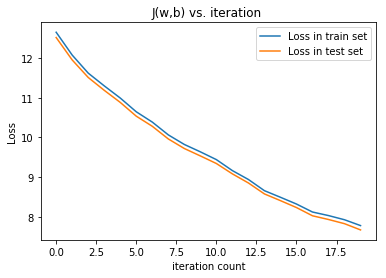

Gradient Descent
Current Loss: (iter : 1 ) 18.629697199581543 19.12405264996806
Current Loss: (iter : 11 ) 11.24244735376069 11.363740916738886


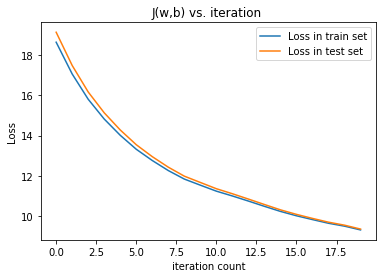

Gradient Descent
Current Loss: (iter : 1 ) 19.73368113704857 19.93511558712778
Current Loss: (iter : 11 ) 14.149457070490083 14.249134288231776


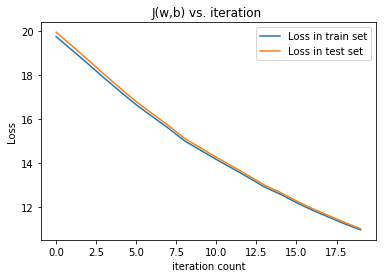

Gradient Descent
Current Loss: (iter : 1 ) 13.326726566072276 13.371605533872145
Current Loss: (iter : 11 ) 9.003536381041839 8.968039209898558


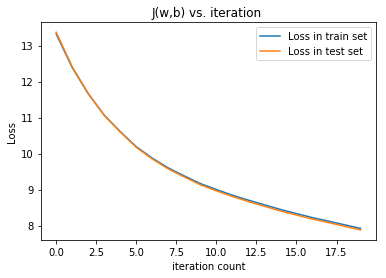

In [6]:
lr = 0.01
batch_size_list = [16, 64, 256, 1024]
n = X_train.shape[0]
for batch_size in batch_size_list:
#     max_steps = n/batch_size+1
    max_steps = 20
    J_train, J_test,runtime = gradient_descent(X_train, Y_train ,X_test, Y_test,lr, batch_size,max_steps)
    draw_loss(J_train, J_test)

    

In [65]:
def adam_optimizer(dJ_w1, dJ_w2, w1,w2):
    alpha = 0.01
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    m1_t, m2_t, v1_t, v2_t, t = 0.,0.,0.,0.,1;
    while True:
        w1_old = copy.copy(w1)       
        w2_old = copy.copy(w2)     
        m1_t = beta_1*m1_t + (1-beta_1)*dJ_w1
        m2_t = beta_1*m2_t + (1-beta_1)*dJ_w2
        v1_t = beta_2*v1_t +(1. - beta_2) * dJ_w1**2
        v2_t = beta_2*v2_t +(1. - beta_2) * dJ_w2**2
        m1_cap = m1_t/(1.-(beta_1**t))
        m2_cap = m2_t/(1.-(beta_1**t))
        v1_cap = v1_t/(1.-(beta_2**t))
        v2_cap = v2_t/(1.-(beta_2**t))
        w1 -= - (alpha*m1_cap)/(np.sqrt(v1_cap)+epsilon)
        w2 -= - (alpha*m2_cap)/(np.sqrt(v2_cap)+epsilon)
        t += 1.0
        if np.mean((w1_old - w1) ** 2)+ np.mean((w2_old - w2) ** 2) < 1e-3:
            break;
    return w1, w2
def gradient_descent_Adam(X, Y, X_test, Y_test, learning_rate= 0.01, batch_size = 128,max_steps = 1000):
    n,d = X_train.shape
    m,o = Y_test.shape
    print('Gradient Descent')
    w1 = np.random.uniform(-1.0, 1.0, size = (d+1,n_hidden)) 
    w2 = np.random.uniform(-1.0, 1.0, size = (n_hidden+1,o))
    
    w1_list,w2_list, b1_list,b2_list = [],[],[],[]
    iters, delta = 0, 1e-20
    J_train, J_test = [],[]
    loss_old = 0
    start = time.time()
    while iters < max_steps:
        w1_old = copy.copy(w1)       
        w2_old = copy.copy(w2)       
        w1_list.append(w1_old)      
        w2_list.append(w2_old)
        l_train, l_test = 0,0
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        a1, z2, a2, z3, y_hat = forward(batch_x, batch_y, w1,w2)
        dJ_w1, dJ_w2 = backpropagate(batch_y,y_hat,a1, z2, a2, z3, w1,w2)
#         n, d = batch_x.shape
#         for i in range(n):
#             z = forwa
#             mu = -np.sum(np.log(Y_test[i]-(b+np.dot(X_test[i,:], w))))
#             dJ_w += -(1-mu)*Y[i,:]*np.reshape(X[i,:], (d,1))
#             dJ_b += -(1-mu)*Y[i,:]
#             l_train += np.log(1/mu)
#         dJ_w = dJ_w/n+2*lamb*w

        dJ_w1 = dJ_w1/batch_size
        dJ_w2 = dJ_w2/batch_size
        w1, w2 = adam_optimizer(dJ_w1, dJ_w2, w1, w2)
        a1, z2, a2, z3,y_hat_train = forward(X_train, Y_train,w1,w2)
        a1, z2, a2, z3,y_hat_test = forward(X_test, Y_test,w1,w2)
        l_train = compute_cost(Y_train,y_hat_train)
        l_test = compute_cost(Y_test,y_hat_test)
        J_train.append(l_train)
        J_test.append(l_test)
        if iters % 10 == 0:
            print('Current Loss: (iter :', iters+1,')', l_train, l_test)
        if np.mean((w1_old - w1) ** 2)+ np.mean((w2_old - w2) ** 2) < delta:
            break;
        if iters > 100 and np.abs(l_train - loss_old)< 1e-3:
            break;
        loss_old = copy.copy(l_train)
        iters += 1
    end = time.time()
    runtime = end-start
    return J_train, J_test, runtime


Gradient Descent
Current Loss: (iter : 1 ) 26.68337717387166 26.16399832077052
Current Loss: (iter : 11 ) 13.794861111719914 13.510733315554198


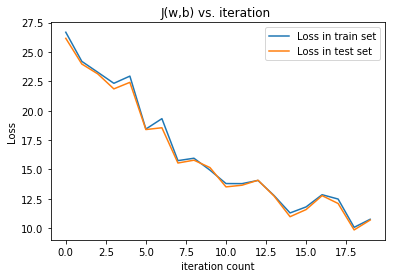

Gradient Descent
Current Loss: (iter : 1 ) 27.894342632538173 27.701856123315817
Current Loss: (iter : 11 ) 9.86208652995717 9.67243500403857


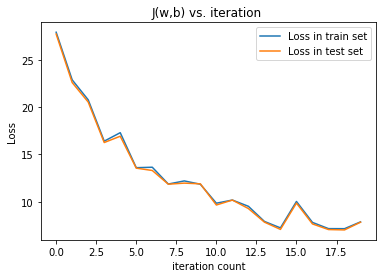

Gradient Descent
Current Loss: (iter : 1 ) 28.24121310197598 28.162725105299735
Current Loss: (iter : 11 ) 8.212122161992083 8.178473215326484


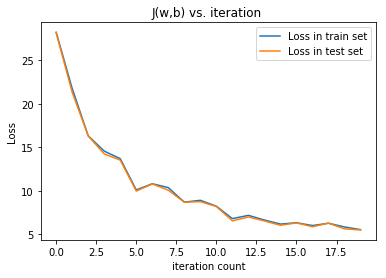

Gradient Descent
Current Loss: (iter : 1 ) 26.93459463837369 26.757734709146817


In [ ]:
for batch_size in batch_size_list:
#     max_steps = n/batch_size+1
    max_steps = 20
    J_train, J_test,runtime = gradient_descent_Adam(X_train, Y_train ,X_test, Y_test,lr, batch_size,max_steps)
    draw_loss(J_train, J_test)

    

In [8]:
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
#learning rate
lr = 0.01
#number of traning steps
num_steps =1000
#number of batch_size
batch_size = 128

#network parameters
n_hidden = 300
num_input = 784
num_classes = 10

In [9]:
tf.reset_default_graph()

In [11]:
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden]),name='W1'),
    'Wout': tf.Variable(tf.random_normal([n_hidden, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden]),name='b1'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}
#define a neural net model
def neural_net(x):
    layer_1_out = tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    out = tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout'])
    return out
#predicted labels
logits = neural_net(X)
#define loss
loss_generic = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
train_op_generic = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss_generic)
#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')
lr = 0.01
init = tf.global_variables_initializer()
for batch_size in batch_size_list:
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_steps):
            #fetch batch
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            #run optimization
            sess.run(train_op_generic, feed_dict={X:batch_x, Y:batch_y})
            if i % 1000 ==0:
                acc = sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y})
                print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
        print("Training finished!") 
        print("Testing ACcuracy:", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}))

step 0, Accuracy= 0.125
Training finished!
Testing ACcuracy: 0.8489
step 0, Accuracy= 0.078
Training finished!
Testing ACcuracy: 0.8461
step 0, Accuracy= 0.090
Training finished!
Testing ACcuracy: 0.8569
step 0, Accuracy= 0.112
Training finished!
Testing ACcuracy: 0.8463


In [12]:
train_op_Adam = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss_generic)

In [13]:
init = tf.global_variables_initializer()
for batch_size in batch_size_list: 
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for i in range(num_steps):
            #fetch batch
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            #run optimization
            sess.run(train_op_Adam, feed_dict={X:batch_x, Y:batch_y})
            if i % 1000 ==0:
                acc = sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y})
                print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
        print("Training finished!") 
        print("Testing ACcuracy:", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}))
print('adagrad optimizer')

step 0, Accuracy= 0.250
Training finished!
Testing ACcuracy: 0.8781
step 0, Accuracy= 0.188
Training finished!
Testing ACcuracy: 0.886
step 0, Accuracy= 0.121
Training finished!
Testing ACcuracy: 0.9049
step 0, Accuracy= 0.172
Training finished!
Testing ACcuracy: 0.8973
adagrad optimizer
